## Pi Cycle top exploration

The goal of this notebook is to explore the Pi Cycle Top indicator for Bitcoin.  Context: Technical analysts have singled out this indicator which is defined as the crossing of two moving averages.  When they cross, it has historically indicated a cycle top price within a few days.  In this notebook we will see how this indicator behaves with respect to tops in Montecarlo simulations of price charts, progressively restricting the random walks to have bitcoin-like properties (e.g. log regression growth, number of peaks)

Table of contents 
1. Imports, data, and Montecarlo simulation basics
2. Log regression curves for Bitcoin
3. Montecarlo and log regression
4. Pi Cycle
5. Number of cycles
6. Conclusion

### 1. Imports, data, and Montecarlo simulation basics

In [2]:
import yfinance as yf
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import io
import pandasql
from pandasql import sqldf
import pandas_ta as ta
import requests
import numpy as np
import scipy
from scipy.optimize import curve_fit
from datetime import datetime

start = dt.datetime(2000, 1, 1)
end = dt.datetime(2021, 1, 1)
stock_data = yf.download('MSFT', start, end)

[*********************100%***********************]  1 of 1 completed


In [3]:
stock_data # example dataset

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,58.687500,59.312500,56.000000,58.281250,36.555374,53228400
2000-01-04,56.781250,58.562500,56.125000,56.312500,35.320534,54119000
2000-01-05,55.562500,58.187500,54.687500,56.906250,35.692932,64059600
2000-01-06,56.093750,56.937500,54.187500,55.000000,34.497292,54976600
2000-01-07,54.312500,56.125000,53.656250,55.718750,34.948109,62013600
...,...,...,...,...,...,...
2020-12-24,221.419998,223.610001,221.199997,222.750000,219.464478,10550600
2020-12-28,224.449997,226.029999,223.020004,224.960007,221.641876,17933500
2020-12-29,226.309998,227.179993,223.580002,224.149994,220.843796,17403200


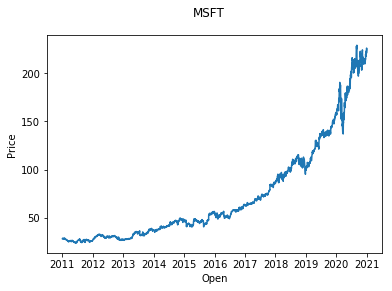

In [124]:
fig = plt.figure()
fig.suptitle("MSFT")
plt.plot(stock_data[['Open']])
plt.xlabel('Open')
plt.ylabel('Price')
plt.show()

In [93]:
returns = stock_data['Adj Close'].pct_change()
daily_vol = 8*returns.std()
T = 1000
last_price = stock_data['Adj Close'][-1]

In [96]:
# Generate random walks, using historical volatitlity as parameters
NUM_SIMULATIONS =  10
df = pd.DataFrame()
last_price_list = []
for x in range(NUM_SIMULATIONS):
    count = 0
    price_list = []
    price = last_price * (1 + np.random.normal(0, daily_vol))
    price_list.append(price)
    
    for y in range(T):
        if count == T:
            break
        price = price_list[count]* (1 + np.random.normal(0, daily_vol))
        price_list.append(price)
        count += 1
        
    df[x] = price_list
    last_price_list.append(price_list[-1])

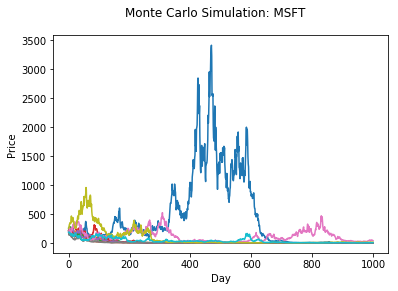

In [97]:
fig = plt.figure()
fig.suptitle("Monte Carlo Simulation: MSFT")
plt.plot(df)
plt.xlabel('Day')
plt.ylabel('Price')
plt.show()

In [110]:
col_list = ['series_' + str(i) for i in range(len(df.columns))]

df.columns = col_list

In [111]:
df

,series_0,series_1,series_2,series_3,series_4,series_5,series_6,series_7,series_8,series_9
0,212.048578,215.136861,250.664496,216.964709,193.976873,210.490173,200.555769,181.036461,255.156588,181.530795
1,210.774518,211.207538,233.792901,164.730111,157.343501,213.599971,208.604191,135.674896,260.708250,179.382128
2,169.901712,246.211986,267.576943,164.688639,216.981573,240.521405,225.385882,158.424315,310.698954,184.834049
3,170.917643,252.881965,285.181025,186.077188,217.064055,232.765185,260.665638,134.746845,321.830504,178.967818
4,166.763449,210.441519,284.071926,209.804718,234.227061,226.986807,209.944308,152.064601,347.667733,178.402799
...,...,...,...,...,...,...,...,...,...,...
996,1.421441,0.000700,0.000149,1.342524,0.030804,0.002713,50.207086,0.000788,12.707393,4.149594
997,1.280093,0.000725,0.000153,1.309668,0.029569,0.002401,44.575678,0.000686,10.651629,4.808644
998,1.251241,0.000700,0.000162,1.562621,0.028515,0.002499,44.695772,0.000560,12.120554,4.274340
999,1.224913,0.000595,0.000129,1.375431,0.021072,0.002442,42.221515,0.000497,14.080061,5.215690


In [112]:
# calculate moving averages involved in pi cycle top
df.ta.sma(close='series_0', length=350, append=True)
df.ta.sma(close='series_0', length=111, append=True)
#df['ma_0'] = ma_0

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
996     4.363057
997     4.308227
998     4.244688
999     4.193548
1000    4.160444
Name: SMA_111, Length: 1001, dtype: float64

In [113]:
df['dSMA_350']=2*df['SMA_350'] 
# the 350 is multiplied by 2, and then the cross with the 110 is used to define the pi cycle top

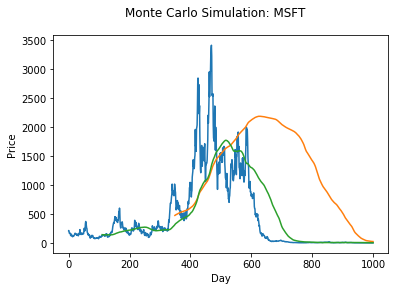

In [114]:
fig = plt.figure()
fig.suptitle("Monte Carlo Simulation: MSFT")
plt.plot(df[['series_0','dSMA_350','SMA_111']])
plt.xlabel('Day')
plt.ylabel('Price')
plt.show()

In this case, it doesn't quite work to indicate the top.

In [4]:
url="https://pkgstore.datahub.io/core/nasdaq-listings/nasdaq-listed_csv/data/7665719fb51081ba0bd834fde71ce822/nasdaq-listed_csv.csv"
s = requests.get(url).content


In [7]:
companies = pd.read_csv(io.StringIO(s.decode('utf-8')))

In [8]:
companies.head()

,Symbol,Company Name,Security Name,Market Category,Test Issue,Financial Status,Round Lot Size
0,AAIT,iShares MSCI All Country Asia Information Tech...,iShares MSCI All Country Asia Information Tech...,G,N,N,100.0
1,AAL,"American Airlines Group, Inc.","American Airlines Group, Inc. - Common Stock",Q,N,N,100.0
2,AAME,Atlantic American Corporation,Atlantic American Corporation - Common Stock,G,N,N,100.0
3,AAOI,"Applied Optoelectronics, Inc.","Applied Optoelectronics, Inc. - Common Stock",G,N,N,100.0
4,AAON,"AAON, Inc.","AAON, Inc. - Common Stock",Q,N,N,100.0


In [10]:
symbols = companies['Symbol'].tolist()


This takes a while to execute maybe like 30 mins.  Ran it and saved the csv
## create empty dataframe
stock_final = pd.DataFrame()
## iterate over each symbol
for i in symbols:  
    
    # print the symbol which is being downloaded
    print( str(symbols.index(i)) + str(' : ') + i, sep=',', end=',', flush=True)  
    
    try:
        # download the stock price 
        stock = []
        stock = yf.download(i,start=start, end=end, progress=False)
        
        # append the individual stock prices 
        if len(stock) == 0:
            None
        else:
            stock['Name']=i
            stock_final = stock_final.append(stock,sort=False)
    except Exception:
        None

In [ ]:
stock_final = pd.read_csv("stock_final.csv") 
# Should work, did not try, but can be used to not download again when re running

In [14]:
stock_final.head()

,Open,High,Low,Close,Adj Close,Volume,Name
Date,,,,,,,
2002-06-06,0.03542,0.03542,0.03542,0.03542,0.03542,0.0,AAIT
2002-06-10,0.03409,0.03409,0.03409,0.03409,0.03409,0.0,AAIT
2002-06-12,0.03453,0.03453,0.03453,0.03453,0.03453,0.0,AAIT
2002-06-13,0.03542,0.03542,0.03542,0.03542,0.03542,0.0,AAIT
2002-06-18,0.03586,0.03586,0.03586,0.03586,0.03586,0.0,AAIT


In [15]:
#stock_final.to_csv("stock_final.csv")

In [18]:
stock_final['Price'] = (stock_final['Open'] + stock_final['High'] + stock_final['Low'] + stock_final['Close'])/4

In [21]:
stock_final.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Name', 'Price'], dtype='object')

In [22]:
stock_final = stock_final.drop('Open', 1)
stock_final = stock_final.drop('High', 1)
stock_final = stock_final.drop('Low', 1)
stock_final = stock_final.drop('Close', 1)
stock_final = stock_final.drop('Adj Close', 1)
stock_final = stock_final.drop('Volume', 1)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/site-packages/ipyker

In [24]:
stock_final.head()

,Name,Price
Date,,
2002-06-06,AAIT,0.03542
2002-06-10,AAIT,0.03409
2002-06-12,AAIT,0.03453
2002-06-13,AAIT,0.03542
2002-06-18,AAIT,0.03586


In [23]:
stock_final.to_csv("stock_final_prices_only.csv")

## Volatility
We can define global and daily volatility.

Global -> deviation from the mean over a period of time

Daily -> we get the consecutive day prices, substract them, and see the mean and sd of that.

In [38]:
# GLOBAL
#df = sqldf("select avg(Price), Name from stock_final group by Name order by Name")
df_global_vol = stock_final.groupby(['Name'])['Price'].agg(['mean','std'])

In [37]:
df_global_vol

,mean,std
Name,,
AAIT,1.877364,7.161556
AAL,26.379548,16.600505
AAME,2.646006,0.944205
AAOI,22.091251,15.823361
AAON,15.325804,15.722072
...,...,...
ZEUS,18.784378,10.597128
ZION,42.653235,19.083107
ZIV,43.703704,21.275281


In [43]:
df_daily_vol = stock_final
df_daily_vol['diff_daily'] = stock_final.Price.diff()
df_daily_vol = df_daily_vol.reset_index()

In [51]:
df_daily_vol[df_daily_vol['Name']=='TSLA'].head()

,Name,Price,diff_daily
Date,,,
2010-06-29,TSLA,4.2715,-21.5785
2010-06-30,TSLA,5.1670,0.8955
2010-07-01,TSLA,4.6575,-0.5095
2010-07-02,TSLA,4.2005,-0.4570
2010-07-06,TSLA,3.5970,-0.6035


In [ ]:
#drop the first row of each ticker since it calculates diff_daily using other ticker
# takes a bit to execute, maybe 30 mins 
for name in df_daily_vol.Name.unique():
    min_date = min(df_daily_vol[df_daily_vol["Name"]==name].Date)
    df_daily_vol.drop(df_daily_vol.index[(df_daily_vol['Name'] == name) & (df_daily_vol['Date'] == min_date)], inplace=True)
    print(min_date)
    print(name)
    

In [76]:
# Now write this file since it took long to execute:
df_daily_vol.to_csv('daily_vol.csv')

In [74]:
df_daily_vol.head()

,Date,Name,Price,diff_daily
1,2002-06-10,AAIT,0.03409,-0.00133
2,2002-06-12,AAIT,0.03453,0.00044
3,2002-06-13,AAIT,0.03542,0.00089
4,2002-06-18,AAIT,0.03586,0.00044
5,2002-06-24,AAIT,0.03409,-0.00177


In [95]:
df_daily_vol['diff_perc'] = df_daily_vol['diff_daily']/df_daily_vol['Price']

In [99]:
df_AAIT = df_daily_vol[df_daily_vol['Name']=='TSLA']

In [100]:
df_AAIT.head()

,Date,Name,Price,diff_daily,diff_perc
6278437,2010-06-30,TSLA,5.1670,0.8955,0.173311
6278438,2010-07-01,TSLA,4.6575,-0.5095,-0.109393
6278439,2010-07-02,TSLA,4.2005,-0.4570,-0.108797
6278440,2010-07-06,TSLA,3.5970,-0.6035,-0.167779
6278441,2010-07-07,TSLA,3.1905,-0.4065,-0.127409


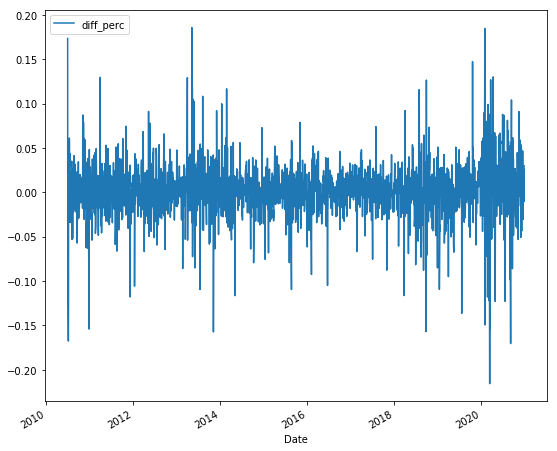

In [101]:
df_AAIT.plot(x="Date", y=["diff_perc"], kind="line", figsize=(9, 8))

In [102]:
df_AAIT['diff_daily_round'] = round(df_AAIT['diff_daily']*100000)/100000
#df_AAIT.groupby('diff_daily_round').count().plot.bar()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x123e756d0>,
      dtype=object)

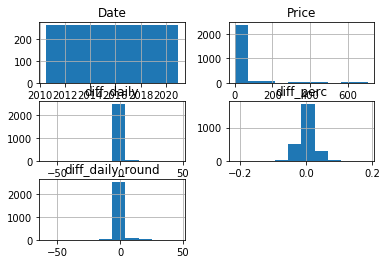

In [103]:
df_AAIT.hist()

We can do lots of EDA on this.  Filter for stocks that make sense (AAIT was really weird, TSLA made sense).
We can see if we can fit a band, a generalization of the log regression for btc.  Maybe they are oscillators, or constant, or decreasing or undesciferable?
Then within those bands you can run similar analysis as we do with btc, might be good for swingtrading different stocks taking into account indicators and relative valuations.

# 2. Log regression curves for Bitcoin

In [120]:
#start = dt.datetime(2015, 9, 18)
#end = dt.datetime(2016, 6, 23)
#btc_data = yf.download('BTC', start, end)
# Only has data after 2020, so we fetch manually a csv from website

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- BTC: Data doesn't exist for startDate = 1442530800, endDate = 1466636400


 downloaded csv manually from 
this has only as from 2014 https://finance.yahoo.com/quote/BTC-USD/history?period1=1410912000&period2=1655942400&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true
so ended up using data from investing.com which needs login

In [339]:
btc_data = pd.read_csv('bitcoin_history_investing.csv')

In [340]:
btc_data.head(280)

,Date,Price,Open,High,Low,Vol.,Change %
0,"Jul 18, 2010",0.1,0.0,0.1,0.1,0.08K,0.00%
1,"Jul 19, 2010",0.1,0.1,0.1,0.1,0.57K,0.00%
2,"Jul 20, 2010",0.1,0.1,0.1,0.1,0.26K,0.00%
3,"Jul 21, 2010",0.1,0.1,0.1,0.1,0.58K,0.00%
4,"Jul 22, 2010",0.1,0.1,0.1,0.1,2.16K,0.00%
...,...,...,...,...,...,...,...
275,"Apr 19, 2011",1.2,1.2,1.2,1.1,12.56K,0.00%
276,"Apr 20, 2011",1.1,1.2,1.2,1.1,21.35K,-5.00%
277,"Apr 21, 2011",1.2,1.1,1.2,1.1,39.30K,6.14%
278,"Apr 22, 2011",1.4,1.2,1.4,1.2,39.42K,16.53%


In [341]:
def month(x):
    m = x[0:3]
    dict = {'Jan': '01', 'Feb': '02', 'Mar': '03', 'Apr': '04', 'May': '05', 'Jun': '06', 'Jul': '07',
           'Aug': '08', 'Sep': '09', 'Oct': '10', 'Nov': '11', 'Dec': '12'}
    return dict[m]

def day(x):
    return x[4:6]
    
def year(x):
    return x[8:13]
def remove_comma(x):
    return x.replace(',','')

In [342]:
btc_data['year'] = btc_data['Date'].apply(year)
btc_data['month'] = btc_data['Date'].apply(month)
btc_data['day'] = btc_data['Date'].apply(day)
btc_data['Date'] = btc_data['year']+'-'+btc_data['month']+'-'+btc_data['day']
btc_data = btc_data.drop('year', 1)
btc_data = btc_data.drop('month', 1)
btc_data = btc_data.drop('day', 1)
btc_data = btc_data.drop('Vol.', 1)
btc_data = btc_data.drop('Change %', 1)
btc_data['Open'] = btc_data['Open'].apply(remove_comma)
btc_data['High'] = btc_data['High'].apply(remove_comma)
btc_data['Low'] = btc_data['Low'].apply(remove_comma)
btc_data.Open = btc_data.Open.astype(float)
btc_data.High = btc_data.High.astype(float)
btc_data.Low = btc_data.Low.astype(float)
btc_data['Price'] =  btc_data['Open'] + 0.0000001 #(btc_data['Open'] + btc_data['High'] + btc_data['Low'])/3
btc_data = btc_data.drop('High', 1)
btc_data = btc_data.drop('Low', 1)
btc_data = btc_data.drop('Open', 1)
#btc_data = btc_data[btc_data['Date']>'2011-04-19'] # taking out values under 1 (before this date), 
#due to sensitivity in the fit


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


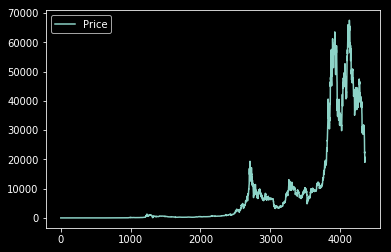

In [276]:
btc_data.plot()

Below we plot the log chart

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


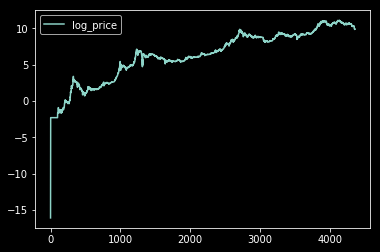

In [343]:
btc_log = btc_data
btc_log['log_price']= np.log(btc_log['Price'])
btc_log = btc_log.drop('Price',1)
btc_log.plot()

In [345]:
#this is the function we want to fit over our data: a.log(x)+b
#we need to find appropriate coefficients
def func(x, p1, p2, p3):
    return p1*np.log(p3+x) + p2

#we are fitting log of price of BTC against the function, not actual price
ydata = np.log(btc_data["Price"])
xdata = [x+1 for x in range(len(btc_data))] #just use numbers for dates

extended_dates = pd.date_range(btc_data["Date"].iloc[0], "2023-01-01")

#extract optimal coefficients using curve fit
popt, pcov = curve_fit(func, xdata, ydata, p0=(3.0, -10, 1))

#try to get ydata from xdata and function
#popt has coefficients, pcov has covariances between them
print(popt)

#generate fitted Y data
fittedYdata = func(np.array([x+1 for x in range(len(btc_data))]), popt[0], popt[1], popt[2])#pass values to function


[  5.56089893 -36.66557292 469.43264861]


/usr/local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


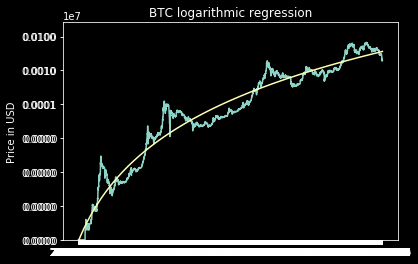

In [346]:
# this takes a min or 2 to run unfortunately, I think the ~10 years of daily data is too much to plot for my local setup
#plt.style.use("dark_background")
fig, ax = plt.subplots()
ax.semilogy(btc_data["Date"], btc_data["Price"])
plt.yscale('log', subsy=[1])
ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())
plt.plot(btc_data["Date"], np.exp(fittedYdata)) #exponentiate the data

plt.title("BTC logarithmic regression")
plt.ylabel("Price in USD")
plt.ylim(bottom=0.1)
plt.show()


So we managed to fit a log curve.  Let's try to fit upper and lower regression fits (we call them upper and lower bands, although curve would be a better name).  The process is a bit handwavy, but I was looking for something "good enough" from a visual perspective.  A more rigurous mathematical definition could involve doing the fits by only considering top and lower points, but that is beyond the scope of this notebook.

In [347]:
# Try to fit to only top points for upper band

# we use the sigma parameter which basically gives more weight to certain points, "forcing" the curve to go through them. 
# So we choose points in the peak of bubbles.  Might not be the most elegant solution, but does the job.
btc_data['upper_sigma'] = 1
btc_data['upper_sigma'][btc_data['Date']=='2011-06-09'] = 0.0001
btc_data['upper_sigma'][btc_data['Date']=='2013-12-05'] = 0.0001
btc_data['upper_sigma'][btc_data['Date']=='2017-12-17'] = 0.0001
btc_data['upper_sigma'][btc_data['Date']=='2017-12-18'] = 0.0001


#this is the function we want to fit over our data: a.log(x)+b      
#we need to find appropriate coefficients
def func(x, p1, p2, p3):
    return p1*np.log(p3+x) + p2

#we are fitting log of price of BTC against the function, not actual price
ydata = np.log(btc_data["Price"])
xdata = [x+1 for x in range(len(btc_data))] #just use numbers for dates

extended_dates = pd.date_range(btc_data["Date"].iloc[0], "2023-01-01")

#extract optimal coefficients using curve fit
popt, pcov = curve_fit(func, xdata, ydata, p0=(3.0, -10, 1), sigma = btc_data['upper_sigma'])

#try to get ydata from xdata and function
#popt has coefficients, pcov has covariances between them
print(popt)

#generate fitted Y data
fittedYdata_top = func(np.array([x+1 for x in range(len(btc_data))]), popt[0], popt[1], popt[2])#pass values to function
btc_data['upper_band'] = fittedYdata_top


[  4.01211277 -22.22736796 265.55590641]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value

In [348]:
#btc_data[(btc_data['Date']>'2017-12-01') & (btc_data['Date']<'2018-01-15')]

#btc_data['upper_exp']=np.exp(btc_data_top['upper_band'])
#btc_data

In [175]:
#btc_data['upper_band'] = np.exp(btc_data['log_fit']+1.5)

/usr/local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


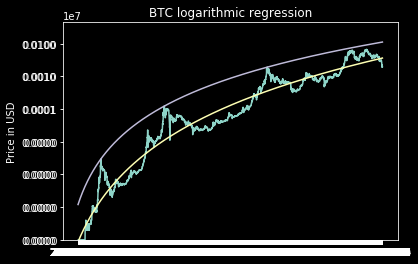

In [282]:
# this takes a min or 2 to run unfortunately, I think the ~10 years of daily data is too much to plot for my local setup
#plt.style.use("dark_background")
fig, ax = plt.subplots()
ax.semilogy(btc_data["Date"], btc_data["Price"])
plt.yscale('log', subsy=[1])
ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())
plt.plot(btc_data["Date"], np.exp(fittedYdata), np.exp(fittedYdata_top)) #exponentiate the data

plt.title("BTC logarithmic regression")
plt.ylabel("Price in USD")
plt.ylim(bottom=0.1)
plt.show()


In [349]:
# Finally repeat the same but with lower band
# Try to fit to only top points for upper band

# we use the sigma parameter which basically gives more weight to certain points, "forcing" the curve to go through them. 
# So we choose points in the peak of bubbles.  Might not be the most elegant solution, but does the job.
btc_data['lower_sigma'] = 1
btc_data['lower_sigma'][btc_data['Date']=='2010-07-18'] = 0.001
btc_data['lower_sigma'][btc_data['Date']=='2013-01-03'] = 0.001
btc_data['lower_sigma'][btc_data['Date']=='2015-01-15'] = 0.001
btc_data['lower_sigma'][btc_data['Date']=='2018-12-16'] = 0.001

btc_data['lower_sigma'][btc_data['Date']=='2020-03-17'] = 0.001

# Going to fake the data for this data point to force the band to go down.  Hacky AF, needs to be revisited.
btc_data['aux_price'] = btc_data['Price']
btc_data['aux_price'][btc_data['Date']=='2015-01-15'] = btc_data['Price'][btc_data['Date']=='2015-01-15']/4

#this is the function we want to fit over our data: a.log(x)+b      
#we need to find appropriate coefficients
def func(x, p1, p2, p3):
    return p1*np.log(p3+x) + p2

#we are fitting log of price of BTC against the function, not actual price
ydata = np.log(btc_data["aux_price"])
xdata = [x+1 for x in range(len(btc_data))] #just use numbers for dates

extended_dates = pd.date_range(btc_data["Date"].iloc[0], "2023-01-01")

#extract optimal coefficients using curve fit
popt, pcov = curve_fit(func, xdata, ydata, p0=(3.0, -10, 1), sigma = btc_data['lower_sigma'])

#try to get ydata from xdata and function
#popt has coefficients, pcov has covariances between them
print(popt)

#generate fitted Y data
fittedYdata_bottom = func(np.array([x+1 for x in range(len(btc_data))]), popt[0], popt[1], popt[2])#pass values to function
btc_data['lower_band'] = fittedYdata_bottom


[  4.71146551 -30.13866229  18.61893831]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: Setti

/usr/local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


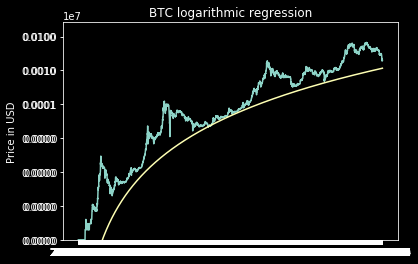

In [331]:
# this takes a min or 2 to run unfortunately, I think the ~10 years of daily data is too much to plot for my local setup
#plt.style.use("dark_background")
fig, ax = plt.subplots()
ax.semilogy(btc_data["Date"], btc_data["Price"])
plt.yscale('log', subsy=[1])
ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())
plt.plot(btc_data["Date"], np.exp(fittedYdata_bottom)) #exponentiate the data

plt.title("BTC logarithmic regression")
plt.ylabel("Price in USD")
plt.ylim(bottom=0.1)
plt.show()


In [332]:
#btc_data[btc_data['Date']>'2014-12-01'].head(60)

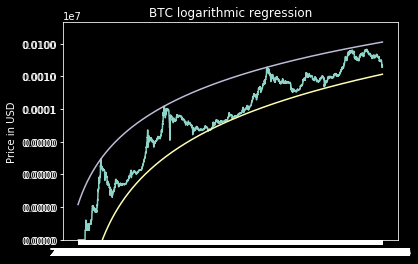

In [335]:
# this takes a min or 2 to run unfortunately, I think the ~10 years of daily data is too much to plot for my local setup
#plt.style.use("dark_background")
fig, ax = plt.subplots()
ax.semilogy(btc_data["Date"], btc_data["Price"])
plt.yscale('log', subsy=[1])
ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())
plt.plot(btc_data["Date"], np.exp(fittedYdata_bottom), np.exp(fittedYdata_top)) #exponentiate the data

plt.title("BTC logarithmic regression")
plt.ylabel("Price in USD")
plt.ylim(bottom=0.1)
plt.show()

In [355]:
df = btc_data
df['upper_band'] = np.exp(fittedYdata_top)
df['lower_band'] = np.exp(fittedYdata_bottom)
df = df.drop('log_price', 1)
df = df.drop('upper_sigma', 1)
df = df.drop('lower_sigma', 1)
df = df.drop('aux_price', 1)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  import sys


In [361]:
pd.set_option('display.float_format', str)
df = df.round(decimals=2)

In [362]:
df

,Date,Price,upper_band,lower_band
0,2010-07-18,0.0,1.2,0.0
1,2010-07-19,0.1,1.22,0.0
2,2010-07-20,0.1,1.24,0.0
3,2010-07-21,0.1,1.26,0.0
4,2010-07-22,0.1,1.27,0.0
...,...,...,...,...
4354,2022-06-19,18983.4,112187.19,11604.91
4355,2022-06-20,20576.9,112284.63,11617.42
4356,2022-06-21,20571.6,112382.14,11629.93
4357,2022-06-22,20720.2,112479.71,11642.46


# 3. Montecarlo and log regression

Now we have that we have the bands, we can generate random walks within those limits.  The parameters of the random walk will be the desired mu and sigma of the normal dist used to generate the walk.  We get these two from btc historic data. As you can see below, I tried to make them variable and arbitrary to make them "look good".  Once again, a mathematical definition would have been ideal, but I played with parameters to make them look like what I wanted.

In [363]:
df_daily_vol = df
df_daily_vol['diff_daily'] = df.Price.diff()
df_daily_vol = df_daily_vol.reset_index()
df_daily_vol['diff_daily_perc'] = df_daily_vol['diff_daily'] /df_daily_vol['Price']

In [488]:
df_daily_vol['abs_perc'] = abs(df_daily_vol['diff_daily_perc'])
df_daily_vol['abs_perc'][0] = 0.5
df_daily_vol['abs_perc_aux'] = np.float64(df_daily_vol['abs_perc'] + 0.00001)  # to be able to do logs and fits we avoid zeros
df_daily_vol['sigma_abs'] = 1
df_daily_vol['sigma_abs'][0] = 0.01
df_daily_vol['sigma_abs'][500] = 0.01

df_daily_vol['sigma_abs'][1000] = 0.01

df_daily_vol

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,index,Date,Price,upper_band,lower_band,diff_daily,diff_daily_perc,abs_perc,abs_perc_aux,sigma_abs
0,0,2010-07-18,0.0,1.2,0.0,NaN,NaN,0.5,0.50001,0
1,1,2010-07-19,0.1,1.22,0.0,0.1,1.0,1.0,1.00001,1
2,2,2010-07-20,0.1,1.24,0.0,0.0,0.0,0.0,1e-05,1
3,3,2010-07-21,0.1,1.26,0.0,0.0,0.0,0.0,1e-05,1
4,4,2010-07-22,0.1,1.27,0.0,0.0,0.0,0.0,1e-05,1
...,...,...,...,...,...,...,...,...,...,...
4354,4354,2022-06-19,18983.4,112187.19,11604.91,-1463.0,-0.07706733251156273,0.07706733251156273,0.07707733251156272,1
4355,4355,2022-06-20,20576.9,112284.63,11617.42,1593.5,0.07744120834528039,0.07744120834528039,0.07745120834528038,1
4356,4356,2022-06-21,20571.6,112382.14,11629.93,-5.30000000000291,-0.0002576367419161811,0.0002576367419161811,0.00026763674191618113,1
4357,4357,2022-06-22,20720.2,112479.71,11642.46,148.60000000000218,0.00717174544647263,0.00717174544647263,0.0071817454464726295,1


In [531]:
df_daily_vol['abs_perc_aux']

0.023038276513774804

In [533]:
df_daily_vol[df_daily_vol.index > 500].head(60)

,index,Date,Price,upper_band,lower_band,diff_daily,diff_daily_perc,abs_perc,abs_perc_aux,sigma_abs
501,501,2011-12-01,3.0,83.59,0.51,0.20000000000000018,0.06666666666666672,0.06666666666666672,0.06667666666666672,1
502,502,2011-12-02,3.1,84.03,0.52,0.10000000000000009,0.03225806451612906,0.03225806451612906,0.03226806451612906,1
503,503,2011-12-03,3.1,84.47,0.52,0.0,0.0,0.0,1e-05,1
504,504,2011-12-04,2.8,84.91,0.53,-0.30000000000000027,-0.10714285714285725,0.10714285714285725,0.10715285714285724,1
505,505,2011-12-05,2.8,85.35,0.53,0.0,0.0,0.0,1e-05,1
506,506,2011-12-06,2.9,85.8,0.54,0.10000000000000009,0.03448275862068969,0.03448275862068969,0.03449275862068969,1
507,507,2011-12-07,3.0,86.24,0.54,0.10000000000000009,0.03333333333333336,0.03333333333333336,0.033343333333333364,1
508,508,2011-12-08,3.0,86.69,0.55,0.0,0.0,0.0,1e-05,1
509,509,2011-12-09,3.0,87.14,0.55,0.0,0.0,0.0,1e-05,1
510,510,2011-12-10,3.0,87.59,0.56,0.0,0.0,0.0,1e-05,1


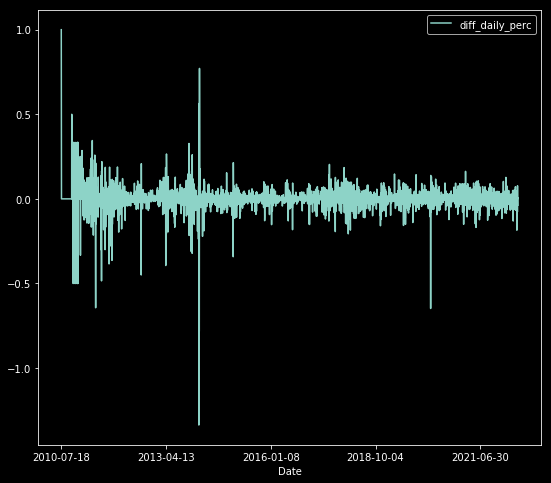

In [483]:
df_daily_vol.plot(x="Date", y=["diff_daily_perc"], kind="line", figsize=(9, 8))

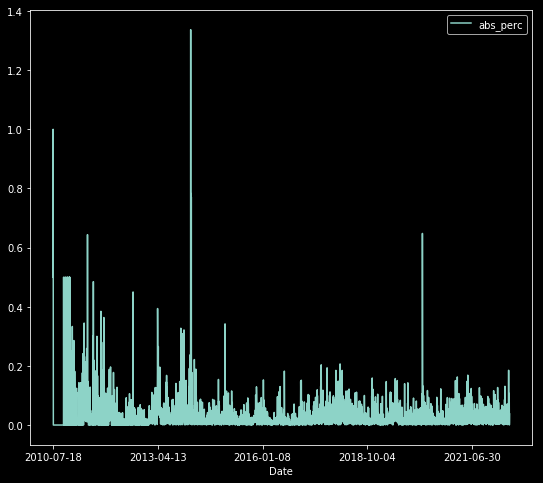

In [484]:
df_daily_vol.plot(x="Date", y=["abs_perc"], kind="line", figsize=(9, 8))

Volatility is greater at the beginning, when marketcap was smaller, which makes sense.  In our experiment below we will assume mu and sigma using all of the data, regardless of this observed variation.  We can refine later and even check the sensitivity of the results to these parameters.

EDIT: the problem is that such small mu at the beginning is at odds with the constraint on the regression bands since we need fast growth at the beginning, let's apply the % change at that day for the random walk to start with.

Proposal: fit a curve in the above abs chart, and use this varying mu for the random walk

In [550]:
#this is the function we want to fit over our data: a.log(x)+b      
#we need to find appropriate coefficients
def func_abs(x, p1, p2):
    return  mu_fixed + p2/(x+p1) #p1 + p2/(p3+x) #p1*np.log(p3+x) + p2

#we are fitting log of price of BTC against the function, not actual price
ydata = df_daily_vol["abs_perc_aux"]
xdata = [x+1 for x in range(len(df_daily_vol))] #just use numbers for dates

extended_dates = pd.date_range(df_daily_vol["Date"].iloc[0], "2023-01-01")

#extract optimal coefficients using curve fit
popt, pcov = curve_fit(func_abs, xdata, ydata)#, sigma = df_daily_vol["sigma_abs"])

#try to get ydata from xdata and function
#popt has coefficients, pcov has covariances between them
print(popt)

#generate fitted Y data
fittedYdata_abs= func_abs(np.array([x+1 for x in range(len(df_daily_vol))]), popt[0], popt[1])#pass values to function
#btc_data['lower_band'] = fittedYdata_bottom


[1.09297112 1.20945424]


In [551]:
fittedYdata_abs

array([0.57885865, 0.39202705, 0.29648932, ..., 0.00127141, 0.00127135,
       0.00127129])

/usr/local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


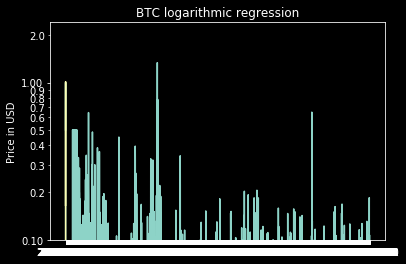

In [491]:
# this takes a min or 2 to run unfortunately, I think the ~10 years of daily data is too much to plot for my local setup
#plt.style.use("dark_background")
fig, ax = plt.subplots()
ax.semilogy(df_daily_vol["Date"], df_daily_vol["abs_perc_aux"])
#plt.yscale('log', subsy=[1])
ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())
plt.plot(df_daily_vol["Date"], fittedYdata_abs) #exponentiate the data

plt.title("BTC logarithmic regression")
plt.ylabel("Price in USD")
plt.ylim(bottom=0.1)
plt.show()


In [501]:
fittedYdata_abs[1]

1.0118880560389125

In [398]:
mu_fixed = np.mean(df_daily_vol['diff_daily_perc'])
sigma_fixed = np.std(df_daily_vol['diff_daily_perc'])
print(mu_fixed)
print(sigma_fixed)

0.0009938938999285417
0.06625132692904236


In [430]:
#df['upper_band'][0]
len(price_list)

4360

In [435]:
#df_test = df[df.index < 4360]
#df_test['test_data'] = price_list[0:4359]

In [439]:
#df_test

Now we proceed to generate simulations.  We use the parameters above and constraint the series to be within the log regression band

In [400]:
df[df.index > 930].head(60)
#price_list


,Date,Price,upper_band,lower_band,diff_daily
931,2013-02-03,19.6,498.02,8.74,-0.8999999999999986
932,2013-02-04,20.6,499.69,8.79,1.0
933,2013-02-05,20.4,501.37,8.83,-0.20000000000000284
934,2013-02-06,20.6,503.04,8.87,0.20000000000000284
935,2013-02-07,21.2,504.73,8.92,0.5999999999999979
936,2013-02-08,22.1,506.41,8.96,0.9000000000000021
937,2013-02-09,22.7,508.11,9.01,0.5999999999999979
938,2013-02-10,23.6,509.8,9.05,0.9000000000000021
939,2013-02-11,24.0,511.5,9.1,0.3999999999999986
940,2013-02-12,24.6,513.21,9.14,0.6000000000000014


In [ ]:
T = len(df)
last_price = 0.8

NUM_SIMULATIONS =  2
dfs = pd.DataFrame()
last_price_list = []
for x in range(NUM_SIMULATIONS):
    count = 0
    price_list = []
    sigma = 1
    mu = 0.0009
    price = last_price * (1 + np.random.normal(mu, sigma))
    while not((price > df['lower_band'][count]) & (price < df['upper_band'][count])):
        price = last_price * (1 + np.random.normal(mu, sigma))
    price_list.append(price)
    
    for y in range(T):
        if count == T:
            break
        if count == 0:
            sigma = sigma_fixed
            mu = 0.009
        else:
            sigma = sigma_fixed
            mu = abs(fittedYdata_abs[count])*1.1 #0.009 # abs(df_daily_vol['diff_daily_perc'][count])
            if sigma == 0:
                sigma = sigma_fixed
        price = price_list[count]* (1 + np.random.normal(mu, sigma))
        while not((price > df['lower_band'][count]) &(price < df['upper_band'][count])):
            price = price_list[count] * (1 + np.random.normal(mu, sigma))
        price_list.append(price)
        count += 1
        print(count)
    dfs[x] = price_list
    last_price_list.append(price_list[-1])

In [536]:
#fittedYdata_abs

In [577]:
df_test = df
df_test['test_data'] = price_list[0:4359]

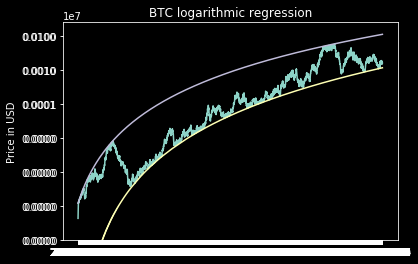

In [664]:
fig, ax = plt.subplots()
ax.semilogy(df_test["Date"], df_test["test_data"])
plt.yscale('log', subsy=[1])
ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())
plt.plot(df_test["Date"], df_test['lower_band'], df_test['upper_band']) #exponentiate the data

plt.title("BTC logarithmic regression")
plt.ylabel("Price in USD")
plt.ylim(bottom=0.1)
plt.show()

Perhapas a bit more sofisticated would be to divide this by bands and see how much time was spent in each band and then modify the distribution for the random walk accordingly.  Lots of work though.. and not quite clear how to make the distribution reflect the pattern.. We could also generate many thousands and then keep the ones with that kind of behaviour, might be easier.

# 4. Pi Cycle

We would like to identify
- Top of a cycle
- bottom of a cycle
- pi cycle top indicator to start an analysis

### Top of a cycle

Let's try using our test data.  From here on p(t) shall denote price at time t.
We can define a cycle as a time interval [a,b] such that

    - p(a) is within 10% of bottom band OR a is the first point in the time series
    - p(b) is within 10% of bottom band
    - there exists c such that p(c) is within 10% of top band
    - the length of the interval should be minimal constrained to the above conditions
    


We can define a point x to be a top if
    
    - there exists a cycle [a,b] where x belongs to the cycle
    - max_p([a,b]) = p(x) i.e. max price of the cycle is x

In [579]:
df_test

,Date,Price,upper_band,lower_band,diff_daily,test_data
0,2010-07-18,0.0,1.2,0.0,NaN,0.4277854362482758
1,2010-07-19,0.1,1.22,0.0,0.1,0.48749861757758517
2,2010-07-20,0.1,1.24,0.0,0.0,0.6703922674192171
3,2010-07-21,0.1,1.26,0.0,0.0,0.9174886619904911
4,2010-07-22,0.1,1.27,0.0,0.0,1.205404918774034
...,...,...,...,...,...,...
4354,2022-06-19,18983.4,112187.19,11604.91,-1463.0,16400.88386874031
4355,2022-06-20,20576.9,112284.63,11617.42,1593.5,17450.54761684814
4356,2022-06-21,20571.6,112382.14,11629.93,-5.30000000000291,16586.167412607945
4357,2022-06-22,20720.2,112479.71,11642.46,148.60000000000218,16798.906544815163


An effective way to find the intervals which generate the cycles is to
    
1. Remove the points where there is a zero
2. Deduplicate the 2's
3. For each 2, find the 1's that are immediately to the left and to the right

This will yield all the cycles in the form of intervals

In [703]:
def identify_cycles(df, column_name):
    df_func = df
    df_func['within_top'] = 2*(df_func[column_name]>df_func['upper_band']*0.82)
    df_func['within_bottom'] = (df_func[column_name]<df_func['upper_band']*0.1) #lower band is tricker bc of "bad" fit
    df_func['within_ext'] = df_func['within_top'] + df_func['within_bottom']
    df_func['within_ext'][0] = 1
    df_func['within_ext'][(len(df_func)-1)] = 1
    #returns array of pairs, each pair is a cycle
    
    sub_df_it = df_func[['Date','within_ext']][df_func['within_ext']!=0]
    sub_df = df_func[['Date','within_ext']][df_func['within_ext']!=0]
    #deduplicate the twos:
    cur = 0
    cnt_two = 0
    for i, row in sub_df_it.iterrows():
        if i==0:
            continue
        if (cur == 2) & (row['within_ext']==2):
            sub_df.drop(i, axis=0, inplace=True)
        cur = row['within_ext']
    # get the intervals    
    cycles_array = []

    for a in sub_df[sub_df['within_ext']==2].index:
        t1 = sub_df.shift()['Date'][sub_df.index==a].values[0]
        t2 = sub_df.shift(-1)['Date'][sub_df.index==a].values[0]
        cycles_array.append([t1,t2])  
    return cycles_array

In [732]:
def identify_tops(df, column_name):
    tops_list = []
    cycles = identify_cycles(df, column_name)
    for interval in cycles:
        a = interval[0]
        b = interval[1]
        temp_df = df[(df['Date']>a) & (df['Date']<b)]
        max_price = max(temp_df[column_name])
        top_date = temp_df[temp_df[column_name] == max_price]['Date']
        tops_list.append(top_date.values[0])
    return tops_list

In [748]:
def identify_bottoms(df, column_name):
    bottoms_list = []
    tops_list = identify_tops(df, column_name)
    n_tops = len(tops_list) - 1
    for n in range(n_tops):
        a = tops_list[n]
        b = tops_list[n+1]
        temp_df = df[(df['Date']>a) & (df['Date']<b)]
        min_price = min(temp_df[column_name])
        min_date = temp_df[temp_df[column_name] == min_price]['Date']
        bottoms_list.append(min_date.values[0])
    return bottoms_list

## Pi-cycle TOP

We finally get to the TA part. Let's extract pi cycle top dates from a time series

In [755]:
df_test = df_test.drop('dSMA_350', 1)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [857]:
def pi_cross(df, column_name):
    sub_df = df
    sub_df.ta.sma(close=column_name, length=350, append=True)
    sub_df.ta.sma(close=column_name, length=111, append=True)
    sub_df['dSMA_350']=2*sub_df['SMA_350']
    sub_df['pi_cross'] = sub_df['dSMA_350']<sub_df['SMA_111']
    crossed = 0
    is_below = 0
    cross_list = []
    for i, row in sub_df.iterrows():
        if (row['pi_cross'] == True) & (crossed == 0):
            cross_list.append(row['Date'])
            crossed = 1
        if row['pi_cross'] == False:
            crossed = 0
    return cross_list

In [770]:
#check cross on test data



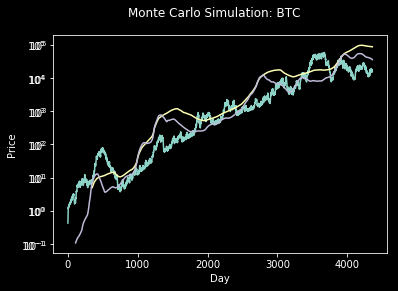

In [769]:
fig = plt.figure()
fig.suptitle("Monte Carlo Simulation: BTC")
plt.yscale('log', subsy=[1])
plt.plot(df_test[['test_data','dSMA_350','SMA_111']])
plt.xlabel('Day')
plt.ylabel('Price')
plt.show()

In [771]:
pi_cross(df_test, 'test_data')

['2011-07-02', '2013-04-07', '2013-12-04', '2017-12-17', '2021-04-13']

In [772]:
identify_tops(df_test,'test_data')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


['2011-11-24', '2020-08-05']

# Generating many series

It seems the pi cycle top won't be working well with any series, let's see the ones for which it does work, and see if we find a pattern

In [ ]:
T = len(df)-1
last_price = 0.8

NUM_SIMULATIONS =  500
dfs = df_test[['Date', 'lower_band', 'upper_band']]
#pd.DataFrame()
last_price_list = []
for x in range(NUM_SIMULATIONS):
    print('simul_num')
    print(x)
    count = 0
    price_list = []
    sigma = 1
    mu = 0.0009
    price = last_price * (1 + np.random.normal(mu, sigma))
    while not((price > df['lower_band'][count]) & (price < df['upper_band'][count])):
        price = last_price * (1 + np.random.normal(mu, sigma))
    price_list.append(price)
    
    for y in range(T):
        if count == T:
            break
        if count == 0:
            sigma = sigma_fixed
            mu = 0.009
        else:
            if count<5:
                sigma = 0.5 # at the beginning mu is high and sometimes it gets stuck if it hits the upper/lowerband
            else:
                sigma = sigma_fixed
            mu = abs(fittedYdata_abs[count])*1.1 #0.009 # abs(df_daily_vol['diff_daily_perc'][count])
            if sigma == 0:
                sigma = sigma_fixed
        price = price_list[count]* (1 + np.random.normal(mu, sigma))
        while not((price > df['lower_band'][count]) & (price < df['upper_band'][count])):
            price = price_list[count] * (1 + np.random.normal(mu, sigma))
        price_list.append(price)
        count += 1
        if (count % 1000) == 0:
            print(count)
    col_name = "series_" + str(x)
    dfs[col_name] = price_list
    last_price_list.append(price_list[-1])

/usr/local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


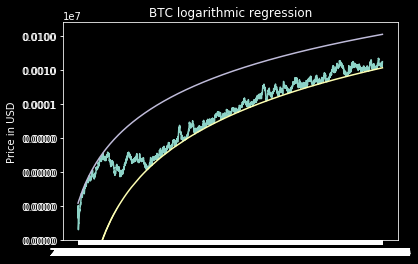

In [818]:
fig, ax = plt.subplots()
ax.semilogy(dfs["Date"], dfs["series_0"])
plt.yscale('log', subsy=[1])
ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())
plt.plot(dfs["Date"], dfs['lower_band'], dfs['upper_band']) #exponentiate the data

plt.title("BTC logarithmic regression")
plt.ylabel("Price in USD")
plt.ylim(bottom=0.1)
plt.show()

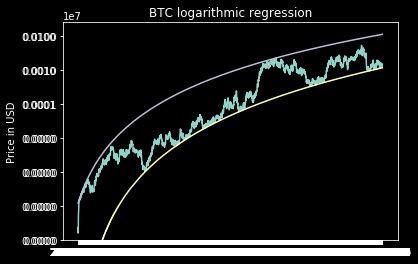

In [819]:
fig, ax = plt.subplots()
ax.semilogy(dfs["Date"], dfs["series_1"])
plt.yscale('log', subsy=[1])
ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())
plt.plot(dfs["Date"], dfs['lower_band'], dfs['upper_band']) #exponentiate the data

plt.title("BTC logarithmic regression")
plt.ylabel("Price in USD")
plt.ylim(bottom=0.1)
plt.show()

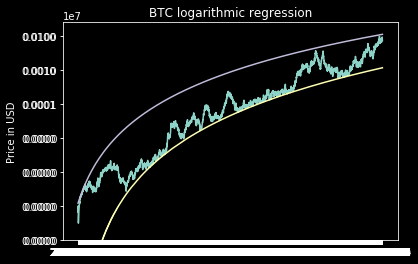

In [820]:
fig, ax = plt.subplots()
ax.semilogy(dfs["Date"], dfs["series_2"])
plt.yscale('log', subsy=[1])
ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())
plt.plot(dfs["Date"], dfs['lower_band'], dfs['upper_band']) #exponentiate the data

plt.title("BTC logarithmic regression")
plt.ylabel("Price in USD")
plt.ylim(bottom=0.1)
plt.show()

/usr/local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


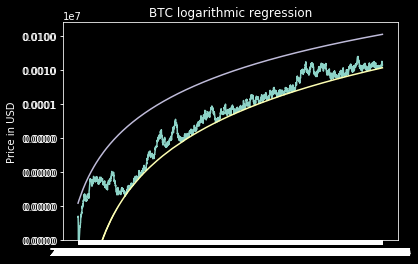

In [864]:
fig, ax = plt.subplots()
ax.semilogy(dfs["Date"], dfs["series_1"])
plt.yscale('log', subsy=[1])
ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())
plt.plot(dfs["Date"], dfs['lower_band'], dfs['upper_band']) #exponentiate the data

plt.title("BTC logarithmic regression")
plt.ylabel("Price in USD")
plt.ylim(bottom=0.1)
plt.show()

### Comparing if dates are near other dates

In [826]:
list_tops = ['2011-07-02', '2013-04-07', '2013-12-04', '2017-12-17', '2021-04-13']

In [828]:
list_cross = ['2011-07-01', '2013-04-12', '2014-04-12']

In [845]:
def get_hits(list_tops, list_cross):
    cross_hits = []
    for a in list_cross:
        b_hits = []
        for b in list_tops:
            d1 = datetime.strptime(a, '%Y-%m-%d')
            d2 = datetime.strptime(b, '%Y-%m-%d')
            if (abs((d1-d2).days)<10):
                b_hits.append(1)
            else:
                b_hits.append(0)
        cross_hits.append(max(b_hits))
    return cross_hits

In [ ]:
list_cols = []
list_hits = []
list_n_tops = []
list_n_cross = []
for col in dfs.columns:
    if col in ['Date','upper_band','lower_band']:
        continue
    list_cols.append(col)
    list_tops = identify_tops(dfs, col)
    list_cross = pi_cross(dfs, col)
    if (len(list_tops)==0) or (len(list_cross)==0):
        list_hits.append(0)
        list_n_tops.append(len(list_tops))
        list_n_cross.append(len(list_cross))
        continue
    cross_hits = get_hits(list_tops, list_cross)
    list_hits.append(sum(cross_hits))
    list_n_tops.append(len(list_tops))
    list_n_cross.append(len(list_cross))
    print(col)

# 5. Number of cycles

Quick check to see how number of cycles makes the pi cycle top behave better

In [884]:
data = {'columns':list_cols,'hits':list_hits, 'n_tops': list_n_tops, 'n_cross':list_n_cross}
meta_df = pd.DataFrame(data)

In [888]:
meta_df[meta_df['hits']>0]

,columns,hits,n_tops,n_cross
23,series_23,1,2,2
138,series_138,1,2,3
148,series_148,1,2,1
187,series_187,1,2,2
190,series_190,1,3,4
210,series_210,1,2,3
253,series_253,1,1,5
300,series_300,1,2,3
326,series_326,1,2,3
339,series_339,1,2,3


In [889]:
meta_df.groupby(['hits']).mean()

,n_tops,n_cross
hits,,
0,1.7061224489795919,1.420408163265306
1,2.0588235294117645,2.6470588235294117


In [874]:
def plot_cross(df, column_name):
    sub_df = df
    sub_df.ta.sma(close=column_name, length=350, append=True)
    sub_df.ta.sma(close=column_name, length=111, append=True)
    sub_df['dSMA_350']=2*sub_df['SMA_350']
    fig = plt.figure()
    fig.suptitle("Monte Carlo Simulation: BTC")
    plt.yscale('log', subsy=[1])
    plt.plot(sub_df[[column_name,'dSMA_350','SMA_111']])
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.show()

def plot_log(dfs, column_name):
    fig, ax = plt.subplots()
    ax.semilogy(dfs["Date"], dfs[column_name])
    plt.yscale('log', subsy=[1])
    ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())
    plt.plot(dfs["Date"], dfs['lower_band'], dfs['upper_band']) #exponentiate the data

    plt.title("BTC logarithmic regression")
    plt.ylabel("Price in USD")
    plt.ylim(bottom=0.1)
    plt.show()


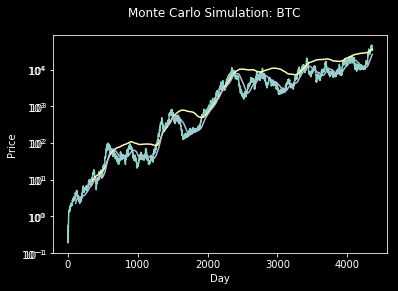

In [873]:
plot_cross(dfs, 'series_23')

/usr/local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


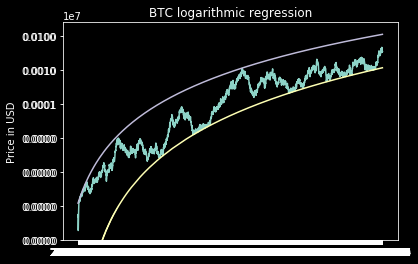

In [875]:
plot_log(dfs, 'series_23')

# 6. Conclusion

This was definitely a messy exploration, but hopefully can serve as basis code for a further notebook.  As can be seen above I wanted to have a better grasp of how these two moving averages behaved with respect to time series in general.  In other words,  if the behaviour of btc price had been different, would this indicator have worked well? In general the answer seems to be 'No'.  And that makes sense, the choice of these two moving averages and that misterious multiplier in one of them points to a mega overfit looking at just one time series.  All the arguments against the validity of TA apply here too, of course.
However, for the next iteration, it might be more interesting to go the other way around: 

- Generate the moving averages (in a way that the two of them can exist for a single time series)
- See what family of curves have this as a valid indicator.

Will we get a family of curves that look a lot like BTC's actual price history? Will it not?
Maybe this is a trivial question for a times series expert, but I fail to come up with an intuitive answer a priori, and would need to run a notebook for it.

One of the points of answering this question is that if we see a family of curves that would fit the general expectation of bitcoin for the next few years, then we can consider the pi cycle top as a signal worth of being taken into account. 